In [8]:
from scipy.fftpack import dct
import librosa
import numpy as np
import pandas as pd

In [9]:
import os

# Leitura de arquivos
path_folder  = "strings/"
all_path_wav_files = []

# Salvando todos os caminhos arquivos wav
for file in os.listdir(path_folder):
    all_path_wav_files.append(os.path.join(path_folder,file))



In [16]:


# Para cada arquivo wav vamos salvar seu QCT e nome da nota associado a ele
note_value = []
qct_frequencies_per_note = []

for path_wav in all_path_wav_files:
    # O path está salvo como TinySOL/Strings/Contrabass/ordinario/Cb-ord-A1-ff-3c-N
    note = path_wav.split('/')[2].split('-')[2]
    y, sr = librosa.load(path_wav, sr=None)
    cqt = librosa.cqt(y, sr=sr, n_bins=84, bins_per_octave=12)

    # Converter a saída para dB
    cqt_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)

    # Extrair as 12 maiores frequências com base no dB
    # Obter as frequências correspondentes às bins do CQT
    frequencies = librosa.cqt_frequencies(n_bins=84, fmin=librosa.note_to_hz('C2'))

    # Encontrar os índices das 12 maiores frequências
    top_indices = np.argsort(np.mean(cqt_db, axis=1))[::-1][:12]

    # Frequências e valores de dB correspondentes
    top_frequencies = frequencies[top_indices]
    top_db_values = np.mean(cqt_db[top_indices], axis=1)
    note_value.append(note)
    qct_frequencies_per_note.append(top_frequencies)


In [18]:
def data_augmetation(qct_frequencies_per_note, note_value):
  new_values = qct_frequencies_per_note.copy()
  new_notes = note_value.copy()
  # Para cada nota, vamos gerar outra variação da nota, porém
  # com pelo menos 3 frequencias dela com +2 semitons vamos gerar outra variação da nota
  # e -2 semitons vamos gerar outra variação da nota
  #As notas variam de acordo com o semiton da forma f = f0 * 2^n/12

  for note, dct in zip(note_value, qct_frequencies_per_note):

    for i in range(2):

      exp = (2+i)/12
      dct_1 = [frequency *2**exp for frequency in dct]
      dct_2 = [frequency *2 **(-exp) for frequency in dct]
      new_values.append(dct_1)
      new_notes.append(note)
      new_values.append(dct_2)
      new_notes.append(note)
        
    for i in range(3):
      exp = (2-i)/12
      dct_1 = [frequency *2**exp for frequency in dct]
      dct_2 = [frequency *2 **(-exp) for frequency in dct]
      new_values.append(dct_1)
      new_notes.append(note)
      new_values.append(dct_2)
      new_notes.append(note)
  return new_values, new_notes


In [19]:
print(f'Tamanho dos dados antes {len(qct_frequencies_per_note)} {len(note_value)}')
qct_frequencies_per_note, note_value = data_augmetation(qct_frequencies_per_note, note_value)
print(f'Tamanho dos dados depois {len(qct_frequencies_per_note)} {len(note_value)}')

Tamanho dos dados antes 309 309
Tamanho dos dados depois 1545 1545


In [20]:
X = np.array(qct_frequencies_per_note)
y = np.array(note_value)


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.preprocessing import StandardScaler;

# Scale the training and test matrices
scaler = StandardScaler();
scaler.fit(X_train);
X_train = scaler.transform(X_train);
X_test = scaler.transform(X_test);
print("Classes em y_train:", len(np.unique(y_train)))
print("Classes em y_test:", len(np.unique(y_test)))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

label_encoder = LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_test= label_encoder.transform(y_test)
print(y_train.shape)
print(y_test.shape)

one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = one_hot_encoder.transform(y_test.reshape(-1, 1))

# Verificar as formas
print("Forma de y_train_one_hot:", y_train.shape)  # Deve ser (n_samples_train, n_classes)
print("Forma de y_test_one_hot:", y_test.shape)  # Deve ser (n_samples_test, n_classes)
print(y_train.shape)
print(y_test.shape)

Classes em y_train: 45
Classes em y_test: 44
(1236, 12)
(1236,)
(309, 12)
(309,)
(1236,)
(309,)
Forma de y_train_one_hot: (1236, 45)
Forma de y_test_one_hot: (309, 45)
(1236, 45)
(309, 45)


In [24]:
import tensorflow as tf;
from tensorflow.keras.models import Model, Sequential;
from tensorflow.keras.layers import Dense, Activation;

import tensorflow.keras.backend as K
K.clear_session();

def createModel():
  model = Sequential();

  model.add(Dense(units = 256,
                  input_shape = (12,),
                  activation = 'sigmoid',
                  name = 'hidden'));

  model.add(Dense(units = 45,
                  activation = 'softmax',
                  name = 'output'));
  return model;

model = createModel();

from tensorflow.keras import optimizers;
opt = optimizers.Adam(learning_rate = 0.001);

print(model.summary());

model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']);

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ hidden (Dense)                       │ (None, 256)                 │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 45)                  │          11,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,893 (58.18 KB)

 Trainable params: 14,893 (58.18 KB)

 Non-trainable params: 0 (0.00 B)

None


In [25]:
hist = model.fit(x = X_train,
                 y = y_train,
                 epochs = 100,
                 batch_size = 1,
                 validation_data = (X_test, y_test))

Epoch 1/100
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0519 - loss: 3.8348 - val_accuracy: 0.0777 - val_loss: 3.2915
Epoch 2/100
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1202 - loss: 3.0870 - val_accuracy: 0.1262 - val_loss: 3.0248
Epoch 3/100
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1893 - loss: 2.7824 - val_accuracy: 0.1294 - val_loss: 2.7861
Epoch 4/100
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2357 - loss: 2.5107 - val_accuracy: 0.2589 - val_loss: 2.5534
Epoch 5/100
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2734 - loss: 2.3396 - val_accuracy: 0.2654 - val_loss: 2.4043
Epoch 6/100
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2963 - loss: 2.2019 - val_accuracy: 0.3010 - val_loss: 2.2647
Epoch 7/100
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3583 - loss: 2.0328 - val_accuracy: 0.2330 - val_loss: 2.2063
Epoch 8/100
1236/1236 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3773 - loss: 1

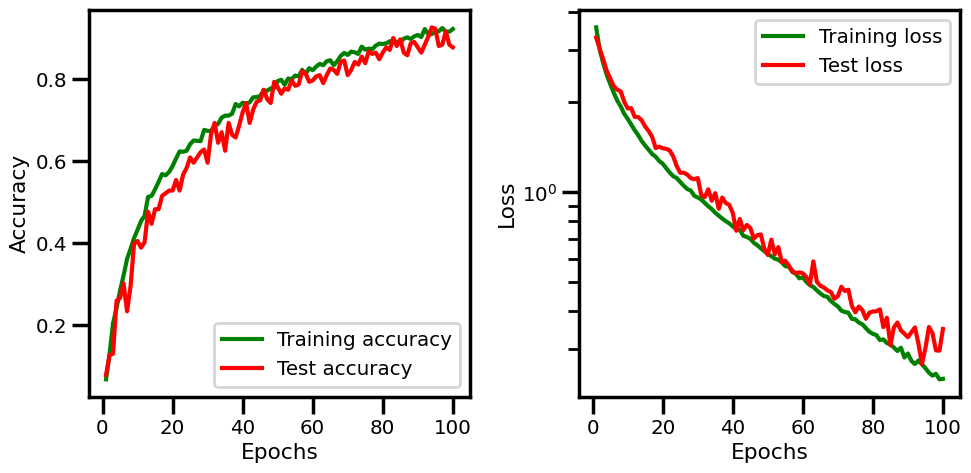

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
# two subplots: one of accuracy vs. epochs, one of loss vs. epochs
# in each subplot, show training in one color and test in another color

trainAcc  = hist.history['accuracy'];
testAcc   = hist.history['val_accuracy'];
trainLoss = hist.history['loss'];
testLoss  = hist.history['val_loss'];
nEpochs   = len(trainAcc);

plt.figure(figsize = (10,5));
sns.set_context("poster", font_scale = .65, rc={"grid.linewidth": 0.6})

# Accuracy Plot
plt.subplot(1,2,1);

sns.lineplot(x     = np.arange(1,nEpochs+1),
             y     = trainAcc,
             label = 'Training accuracy',
             color = 'green');

sns.lineplot(x     = np.arange(1,nEpochs+1),
             y     = testAcc,
             label = 'Test accuracy',
             color = 'red');

plt.xlabel('Epochs');
plt.ylabel('Accuracy');

# Loss Plot
plt.subplot(1,2,2)

sns.lineplot(x     = np.arange(1,nEpochs+1),
             y     = trainLoss,
             label = 'Training loss',
             color = 'green');

sns.lineplot(x     = np.arange(1,nEpochs+1),
             y     = testLoss,
             label = 'Test loss',
             color = 'red');

plt.yscale('log');
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.tight_layout();


In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)  # Obtém as previsões da rede neural
y_pred_classes = y_pred.argmax(axis=1)  # Converte as previsões de one-hot para classes
y_test_classes = y_test.argmax(axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
y_test_labels = label_encoder.inverse_transform(y_test_classes)

cm = confusion_matrix(y_test_labels, y_pred_labels)
labels = label_encoder.classes_
# Plotar a matriz de confusão
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=labels, yticklabels=labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('confusion.png')

In [ ]:
# Prevendo para Resultados
y, sr = librosa.load("E.wav", sr=None)
cqt = librosa.cqt(y, sr=sr, n_bins=84, bins_per_octave=12)

# Converter a saída para dB
cqt_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)

# Extrair as 12 maiores frequências com base no dB
# Obter as frequências correspondentes às bins do CQT
frequencies = librosa.cqt_frequencies(n_bins=84, fmin=librosa.note_to_hz('C2'))

# Encontrar os índices das 12 maiores frequências
top_indices = np.argsort(np.mean(cqt_db, axis=1))[::-1][:84]

# Frequências e valores de dB correspondentes
top_frequencies = frequencies[top_indices]
top_db_values = np.mean(cqt_db[top_indices], axis=1)

# Vamos converter as frequencias de guitarra para contra-baixo
top_frequencies = [frequency/2 for frequency in top_frequencies]
top_frequencies = np.array(top_frequencies).reshape(7,12)

results = [model.predict(top_frequency.reshape(1,-1)) for top_frequency in top_frequencies]



In [ ]:
notes_predicted = []
for result in results:
  predicted_index = np.argmax(result[0])  # Retorna o índice da classe com maior probabilidade
  predicted_label = label_encoder.inverse_transform([predicted_index])
  notes_predicted.append(predicted_label[0])
print(notes_predicted)